# Introduction
This notebook reproduces the results presented in *nanoTabPFN: A Lightweight and Educational Reimplementation of TabPFN*.


# Helper Functions

In [1]:
from matplotlib import pyplot as plt
import functools
import pandas as pd
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import numpy as np
import openml
import pandas as pd
from openml.tasks import TaskType
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, FunctionTransformer

"""
=================== DATA LOADING AND PREPROCESSING ===================
"""

def get_feature_preprocessor(X: np.ndarray | pd.DataFrame) -> ColumnTransformer:
    """
    fits a preprocessor that imputes NaNs, encodes categorical features and removes constant features
    """
    X = pd.DataFrame(X)
    num_mask = []
    cat_mask = []
    for col in X:
        unique_non_nan_entries = X[col].dropna().unique()
        if len(unique_non_nan_entries) <= 1:
            num_mask.append(False)
            cat_mask.append(False)
            continue
        non_nan_entries = X[col].notna().sum()
        numeric_entries = pd.to_numeric(X[col], errors='coerce').notna().sum() # in case numeric columns are stored as strings
        num_mask.append(non_nan_entries == numeric_entries)
        cat_mask.append(non_nan_entries != numeric_entries)
        # num_mask.append(is_numeric_dtype(X[col]))  # Assumes pandas dtype is correct

    num_mask = np.array(num_mask)
    cat_mask = np.array(cat_mask)

    num_transformer = Pipeline([
        ("to_pandas", FunctionTransformer(lambda x: pd.DataFrame(x) if not isinstance(x, pd.DataFrame) else x)), # to apply pd.to_numeric of pandas
        ("to_numeric", FunctionTransformer(lambda x: x.apply(pd.to_numeric, errors='coerce').to_numpy())), # in case numeric columns are stored as strings
    ])
    cat_transformer = Pipeline([
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_mask),
            ('cat', cat_transformer, cat_mask)
        ]
    )
    return preprocessor

def get_openml_datasets(
        max_features_eval: int = 10, 
        new_instances_eval: int = 200, 
        target_classes_filter: int = 2,
        **kwargs,
        ) -> dict[str, tuple[np.ndarray, np.ndarray]]:
    """
    Load OpenML tabarena datasets with at most `max_features` features and subsampled (stratified) to `new_instances` instances.
    """
    task_ids = [
        363612, 363613, 363614, 363615, 363616, 363618, 363619, 363620,
        363621, 363623, 363624, 363625, 363626, 363627, 363628, 363629,
        363630, 363631, 363632, 363671, 363672, 363673, 363674, 363675,
        363676, 363677, 363678, 363679, 363681, 363682, 363683, 363684,
        363685, 363686, 363689, 363691, 363693, 363694, 363696, 363697,
        363698, 363699, 363700, 363702, 363704, 363705, 363706, 363707,
        363708, 363711, 363712
    ] # TabArena v0.1
    datasets = {}
    for task_id in task_ids:
        task = openml.tasks.get_task(task_id, download_splits=False)
        if task.task_type_id != TaskType.SUPERVISED_CLASSIFICATION:
            continue  # skip task, only classification
        dataset = task.get_dataset(download_data=False)

        if dataset.qualities["NumberOfFeatures"] > max_features_eval or (dataset.qualities["NumberOfClasses"] > target_classes_filter) or dataset.qualities["PercentageOfInstancesWithMissingValues"] > 0 or dataset.qualities["MinorityClassPercentage"] < 2.5:
            continue
        X, y, categorical_indicator, attribute_names = dataset.get_data(
            target=task.target_name, dataset_format="dataframe"
        )
        if new_instances_eval < len(y):
            _, X_sub, _, y_sub = train_test_split(
                X, y,
                test_size=new_instances_eval,
                stratify=y,
                random_state=0,
            )
        else:
            X_sub = X
            y_sub = y
        
        X = X_sub.to_numpy(copy=True)
        y = y_sub.to_numpy(copy=True)
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)

        preprocessor = get_feature_preprocessor(X)
        X = preprocessor.fit_transform(X)
        datasets[dataset.name] = (X, y)
    return datasets

"""
=================== EVALUATION ===================
"""

_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

def eval_model(model, datasets):
    """Evaluates a model on multiple datasets and returns metrics"""
    metrics = {}
    for dataset_name, (X,y)  in datasets.items():
        targets = []
        probabilities = []
        
        for train_idx, test_idx in _skf.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test  = y[train_idx], y[test_idx]
            targets.append(y_test)
            model.fit(X_train, y_train)
            y_proba = model.predict_proba(X_test)
            if y_proba.shape[1] == 2:  # binary classification with neural network
                y_proba = y_proba[:, 1]
            probabilities.append(y_proba)
    
        targets = np.concatenate(targets, axis=0)
        probabilities = np.concatenate(probabilities, axis=0)

        metrics[f"{dataset_name}/ROC AUC"] = roc_auc_score(targets, probabilities, multi_class="ovr")
    
    metric_names = list({key.split("/")[-1] for key in metrics.keys()})
    for metric_name in metric_names:
        avg_metric = np.mean([metrics[key] for key in metrics.keys() if key.endswith(metric_name)])
        metrics[f"{metric_name}"] = float(avg_metric)
    
    return metrics

"""
=================== PLOTTING ===================
"""

def plot_runs(
        ax: plt.Axes, 
        runs: list[pd.DataFrame], 
        metric: str, 
        baselines: pd.DataFrame = None,
        baselines_std: pd.DataFrame = None,
        show_legend: bool = True,
        show_xlabel: bool = True,
        show_ylabel: bool = True,
        show_xtics: bool = True
        ):
    """
    Plots the run for a given metric and adds baselines

    `runs` is a list of dataframes where each dataframe corresponds 
    to a run from a model with the same config but a different seed.
    Each dataframe needs to have a `"training_time"` column and a `metric`column.

    `baselines` is a DataFrame with metric columns and rows whose index correspond to
    a ML algorithm.
    """
    colors = sns.color_palette("tab10")[1:]
    linestyles = [
        '--',      # dashed
        '-.',      # dash-dot
        ':',       # dotted
        (0, (3, 1, 1, 1)),  # dash-dot-dot
        (0, (5, 5))         # spaced dash
    ]

    training_times = [run["training_time"].tolist() for run in runs]
    training_times = sorted(set([item for sublist in training_times for item in sublist]))
    shared_time_runs = []
    for run in runs:
        run = run.copy()
        run = run[[metric, "training_time"]].set_index("training_time").reindex(training_times)
        run = run.interpolate()
        shared_time_runs.append(run)
    all_runs = pd.concat(shared_time_runs, axis=1).dropna()
    
    # plot mean and std of all runs or single run if only one run
    mean = all_runs.mean(axis=1)
    ax.plot(mean.index, mean, label="nanoTabPFN", zorder=2, color="blue")
    if all_runs.shape[1] > 1: # more than one run
        std = all_runs.std(axis=1)
        ax.fill_between(mean.index, mean - std, mean + std, alpha=0.2, zorder=2)

    # plot horizontal lines for baselines
    if baselines is not None:
        for i ,(baseline_name, baseline_value) in enumerate(baselines[metric].items()):
            # draw a horizontal line that ends at the same x as the runs
            color = colors[i % len(colors)]
            ax.plot([0, max(training_times)], [baseline_value, baseline_value], label=baseline_name, alpha=0.7, linestyle=linestyles[i], color=color, zorder=1)
            if baselines_std is not None and baseline_name in baselines_std.index:
                    std = baselines_std.loc[baseline_name, metric]
                    ax.fill_between([0, max(training_times)], [baseline_value - std, baseline_value - std], [baseline_value + std, baseline_value + std], alpha=0.2, zorder=1)
    
    # Plot Style
    ax.grid(True, axis="y")
    ax.grid(False, axis="x")
    ax.tick_params(axis="y", length=0)
    if not show_xtics:
        ax.tick_params(axis="x", length=0)
    if show_xlabel:
        ax.set_xlabel("Training time (seconds)")
    if show_ylabel:
        ax.set_ylabel(metric.split("/")[-1])
    max_time = max(training_times)
    ax.set_xlim(0, max_time)
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], 1)
    
    # order legend entries by their y-value at the end of the plot
    if show_legend:
        handles, labels = ax.get_legend_handles_labels()
        label_y_values = {}
        for handle, label in zip(handles, labels):
            if isinstance(handle, plt.Line2D):
                y_data = handle.get_ydata()
                label_y_values[label] = y_data[-1]
        sorted_labels = sorted(label_y_values.items(), key=lambda x: x[1], reverse=True)
        sorted_handles = [handle for label, _ in sorted_labels for handle, lbl in zip(handles, labels) if lbl == label]
        sorted_labels = [label for label, _ in sorted_labels]
        ax.legend(sorted_handles, sorted_labels)
        
    # remove border
    for spine in ax.spines.values():
        spine.set_visible(False)

def plot_run_grid(runs: list[pd.DataFrame], baselines: pd.DataFrame = None, baselines_std: pd.DataFrame = None):
    """Plots the runs in a grid of metrics x datasets"""
    # drop all columns without "/" for dataset/metric format
    datasets = list(set([col.split("/")[0] for col in runs[0].columns if "/" in col]))
    metric = 'ROC AUC'
    figsize = (len(datasets) * 4, 4.6)
    fig, axs = plt.subplots(1, len(datasets), figsize=figsize, sharex=True, sharey=True, layout="constrained")
    fig.set_constrained_layout_pads(w_pad=0.0, h_pad=0.1)
    # Plot each metric and dataset
    for j, dataset in enumerate(datasets):
        ax = axs[j]
        plot_runs(ax, runs, f"{dataset}/{metric}", baselines, baselines_std, show_legend=False, show_xlabel=False, show_ylabel=(j==0))
        ax.set_title(dataset)
    fig.supxlabel("Training Time (seconds)")
    
    # y-axis and x-axis labels should have the same size as supxlabel
    for ax in axs.flatten():
        font_size = fig.texts[-1].get_fontsize() 
        ax.xaxis.label.set_size(font_size)
        ax.yaxis.label.set_size(font_size)
    
    # Create a single legend for the entire figure
    legend_handels_labels = [list(zip(*ax.get_legend_handles_labels())) for ax in axs.flatten()]
    legend_handels_labels = functools.reduce(lambda a, b: a + b, legend_handels_labels)
    unique = dict([(label, handle) for (handle, label) in legend_handels_labels])
    fig.legend(unique.values(), unique.keys(), loc="outside upper center", ncol=3)   
    return fig, axs

# Training and Evaluation

In [2]:
SEEDS = [0, 1]
# SEEDS = [i for i in range(20)] # If you want to reproduce the paper results, use 20 seeds
DATASETS = get_openml_datasets(max_features=10, new_instances=200, target_classes_filter=2)

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
# from tabpfn import TabPFNClassifier
# from tabpfn.config import ModelInterfaceConfig, PreprocessorConfig


# no_preprocessing_inference_config = ModelInterfaceConfig(
#     FINGERPRINT_FEATURE=False,
#     PREPROCESS_TRANSFORMS=[PreprocessorConfig(name='none')]
# )

n_seeds = len(SEEDS)
baseline_models = {
    # "TabPFN v2": [TabPFNClassifier(random_state=i) for i in range(n_seeds)],
    # "TabPFN v2 (no preprocessing)": [TabPFNClassifier(inference_config=no_preprocessing_inference_config, n_estimators=1, random_state=i) for i in range(n_seeds)],
    "Random Forest": [RandomForestClassifier(random_state=i) for i in range(n_seeds)],
    "K-Nearest Neighbors": [KNeighborsClassifier()],
    "Decision Tree": [DecisionTreeClassifier(random_state=i) for i in range(n_seeds)],
}

baseline_models_eval = {name: [eval_model(model, datasets=DATASETS) for model in models] for name, models in baseline_models.items()}

def apply_aggregation(eval_results: dict, func=np.mean):
    aggregated_result = {}
    for result in eval_results:
        for metric, value in result.items():
            if metric not in aggregated_result:
                aggregated_result[metric] = []
            aggregated_result[metric].append(value)
    for metric in aggregated_result:
        aggregated_result[metric] = func(aggregated_result[metric])
    return aggregated_result

baselines = pd.DataFrame({
    name: apply_aggregation(models, np.mean) for name, models in baseline_models_eval.items()
}).T

baselines_std = pd.DataFrame({
    name: apply_aggregation(models, np.std) for name, models in baseline_models_eval.items()
}).T

In [5]:
from model import NanoTabPFNModel
from train import PriorDumpDataLoader, train, get_default_device, set_randomness_seed

histories = []
device = get_default_device()

for seed in [0, 111]:
    set_randomness_seed(seed)
    prior = PriorDumpDataLoader("300k_150x5_2.h5", num_steps=200, batch_size=32, device=device)
    model = NanoTabPFNModel(
            embedding_size=96,
            num_attention_heads=4,
            mlp_hidden_size=192,
            num_layers=3,
            num_outputs=3
        )
    eval_model_partial = functools.partial(eval_model, datasets=DATASETS)
    model, history = train(model, prior, lr=4e-3, steps_per_eval=25, eval_func=eval_model_partial, diag_every=25,   
        dnr_threshold=1e-3,
        aux_lambda=1e-2)
    history = [{**record, "training_time": training_time} for (training_time, record) in history]
    history = pd.DataFrame(history)
    histories.append(history)


[diag] step 25 | time   38.5s | loss 0.4881 | DNR L0: 0.00 | L1: 0.00 | L2: 0.00 | EffRank 1.0 | GradCosPrev -0.9808
time    38.5s | loss  0.4881 | Amazon_employee_access/ROC AUC  0.5248 | blood-transfusion-service-center/ROC AUC  0.4204 | diabetes/ROC AUC  0.7648 | ROC AUC  0.5700
[diag] step 50 | time   73.6s | loss 0.5314 | DNR L0: 0.00 | L1: 0.00 | L2: 0.00 | EffRank 1.0 | GradCosPrev -0.9867
time    73.6s | loss  0.5314 | Amazon_employee_access/ROC AUC  0.5749 | blood-transfusion-service-center/ROC AUC  0.4093 | diabetes/ROC AUC  0.4913 | ROC AUC  0.4919
[diag] step 75 | time  111.9s | loss 0.5367 | DNR L0: 0.00 | L1: 0.00 | L2: 0.00 | EffRank 1.0 | GradCosPrev 0.8946
time   111.9s | loss  0.5367 | Amazon_employee_access/ROC AUC  0.5882 | blood-transfusion-service-center/ROC AUC  0.4594 | diabetes/ROC AUC  0.6264 | ROC AUC  0.5580
[diag] step 100 | time  147.3s | loss 0.4595 | DNR L0: 0.00 | L1: 0.00 | L2: 0.00 | EffRank 1.0 | GradCosPrev -0.9128
time   147.3s | loss  0.4595 | Ama

# Plotting

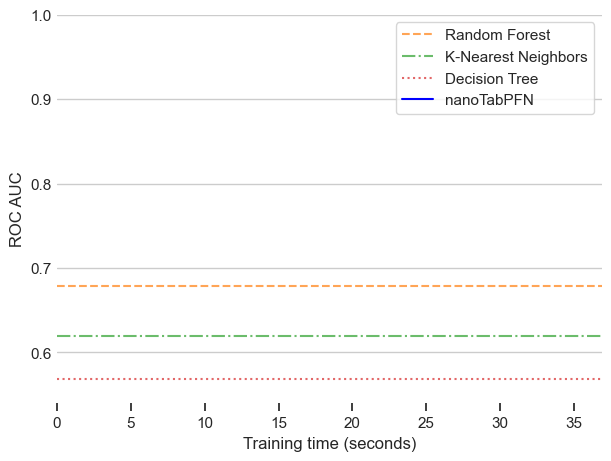

In [12]:
metric = "ROC AUC"
sns.set_style("ticks")
sns.set_context("notebook")
fig, ax = plt.subplots(figsize=(6,4.5), layout="constrained")
plot_runs(ax, histories, metric, baselines)

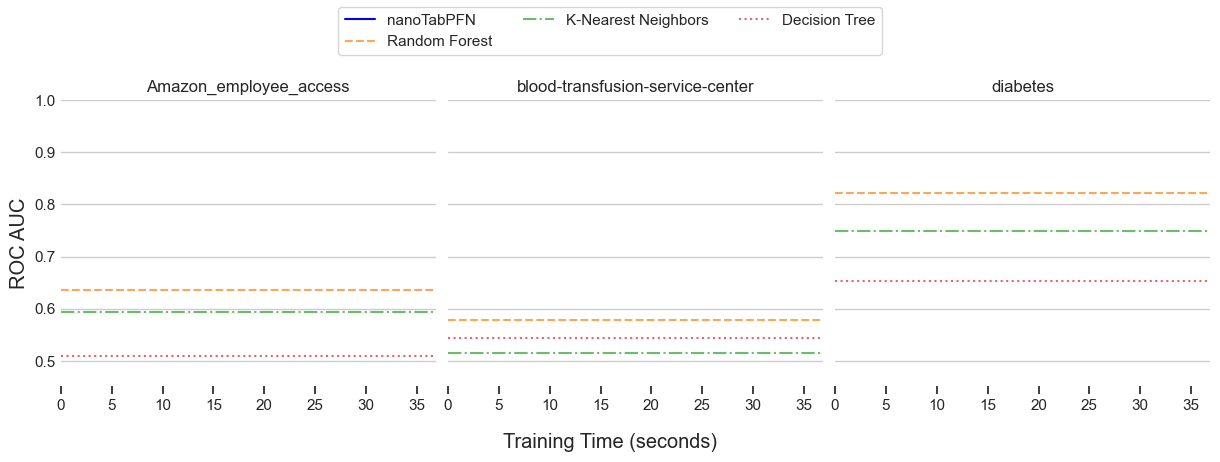

In [13]:
sns.set_context("notebook")
fig, ax = plot_run_grid(histories, baselines)
plt.show()
fig.savefig(f"nanotabpfn_summary.png", dpi=300)
